# Effects of Loan Features on the Estimated Return
## by Luiz Iurk

## Investigation Overview


The intention here is to investigate how the choosen features Term, rating and loan amount can affect the estimated return.<br>
This choice was based on what many economists find as primary foundations for financial planning: Time, Amount and Risk


## Dataset Overview

The original dataset contains 113,937 loan records with 81 features (including LoanStatus, StatedMonthlyIncome, IncomeRange, ProsperRating and many others features that describe the borrower profile).<br>
Besides removing duplications, since the focus of the analysis is to monitor the Estimated return, only records that contained records in that field were considered relevant, remaining around 83k records in total to be evaluated.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import pycountry as pc

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# Loading the prepared data
df_loans_filtered = pd.read_csv("prosper_loans_filtered.csv")

In [3]:
# Functions to operate plotting

def plot_hist(df:pd.DataFrame,target_value:str, labels:list=[],title:str=None, bin_lim:float=0.1, bins = np.arange(0,0), kde=True):
    """ plots a histogram of a target value in a dataframe with a default size of 10% + the max value and 10% - the min value  """
    if bins.size == 0:
        
        bins = np.arange( df[target_value].min()*1-bin_lim, 
                     df[target_value].max()*1+bin_lim, 
                     df[target_value].mean()*bin_lim)
    else:
        bins = bins
    plt.figure(figsize=(8, 4))
    sb.histplot(data=df, x=target_value, bins=bins, kde = kde)
    
    if not labels:
        plt.xlabel(target_value)
        plt.ylabel("Counts")
    else:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    
    if not title:
        plt.title(f"Histogram of {target_value}")
    else:
        plt.title(title)
    
    return plt.show();


In [4]:
default_color = sb.color_palette()[0]

In [5]:
# Selecting the columns that require data adjustment
ordinal_var_dict = {
    
    "LoanStatus": [
        "Cancelled",
        "Defaulted",
        "Chargedoff",
        "Past Due (>120 days)",
        "Past Due (91-120 days)",
        "Past Due (61-90 days)",
        "Past Due (31-60 days)",
        "Past Due (16-30 days)",
        "Past Due (1-15 days)",
        "Current",
        "FinalPaymentInProgress",
        "Completed",
    ],
    "ProsperRatingAlpha": ["HR", "E", "D", "C", "B", "A", "AA"],
    "IncomeRange": [
        "Not displayed",
        "Not employed",
        "$0",
        "$1-24,999",
        "$25,000-49,999",
        "$50,000-74,999",
        "$75,000-99,999",
        "$100,000+",
    ],
    "EmploymentStatus": [
        "Not available",
        "Not employed",
        "Other",
        "Retired",
        "Part-time",
        "Full-time",
        "Self-employed",
        "Employed",
    ],
}
loan_cats = {'0': 'Not Available',
 '1': 'Debt Consolidation',
 '2': 'Home Improvement',
 '3': 'Business',
 '4': 'Personal Loan',
 '5': 'Student Use',
 '6': 'Auto',
 '7': 'Other',
 '8': 'Baby&Adoption',
 '9': 'Boat',
 '10': 'Cosmetic Procedure',
 '11': 'Engagement Ring',
 '12': 'Green Loans',
 '13': 'Household Expenses',
 '14': 'Large Purchases',
 '15': 'Medical/Dental',
 '16': 'Motorcycle',
 '17': 'RV',
 '18': 'Taxes',
 '19': 'Vacation',
 '20': 'Wedding Loans'}
date_cols = ["ListingCreationDate", "ClosedDate", "DateCreditPulled"]

In [6]:
# applying data type changes
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(
        ordered=True, categories=ordinal_var_dict[var]
    )
    df_loans_filtered[var] = df_loans_filtered[var].astype(ordered_var)

unordered_category = pd.api.types.CategoricalDtype(
    ordered=False, categories=loan_cats.values()
)
df_loans_filtered["ListingCategory"] = df_loans_filtered["ListingCategory"].astype(
    unordered_category
)
df_loans_filtered[date_cols] = df_loans_filtered[date_cols].apply(pd.to_datetime)
for col in date_cols:
    df_loans_filtered[col] = df_loans_filtered[col].dt.normalize()

## Distribution of the Estimated Return

The distribution of the Estimated Return is unimodal, but not perfectly distributed, with the biggest peak around 0.1.
Some negative values are identified, but not so many (almost insignificant enough to be discarded)

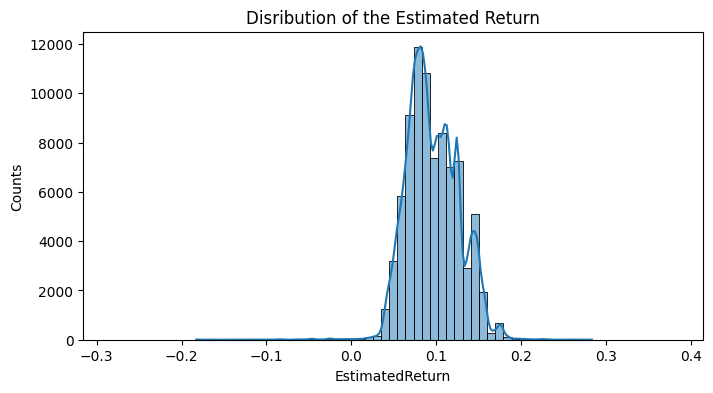

In [7]:
plot_hist(df = df_loans_filtered, target_value="EstimatedReturn", title="Disribution of the Estimated Return")

## Distribution of Original Loan Amount
There are some spikes in some key values around 5k, 10k, 15k, 20k, etc.
Possibly, there are some default loan values

In [8]:
plot_hist(df = df_loans_filtered, target_value="LoanOriginalAmount", title = "Distribution of Original Loan Amount")

## Estimated Return vs. Original Loan Amount

This plot shows that at different size of the loan amount, the Estimated Return has a large range, but the the range of the return decreases with the increase of the loan amount.
We can see that the estimated return is negatively correlated with loan amount.


In [9]:
plt.figure(figsize = [8, 6])
sb.regplot(data = df_loans_filtered, x = 'LoanOriginalAmount', y = 'EstimatedReturn', scatter_kws={'alpha':0.01})
plt.ylabel("Estimated Return (%)");
plt.xlabel("Original Loan Amount ($)")
plt.title("Estimated Return vs. Original Loan Amount");

## Estimated Return vs. Prosper Rating
The estimated return decreases the higher the borrower rating is. We can't avoid to tell that there is a lot of outliers in this plot. But one conclusion can be that the Prosper rating has a strong effect on the estimated return.<br>
In other hand, with the exception of the HR group, the variability of the return decreases the higher the rating is. This makes sense, since groups of higher ratings are more stable.<br> 
This is a clear example that we should not base our conclusions exclusively on averages.

In [10]:
plt.figure(figsize=[9,6])
default_color = sb.color_palette()[0]
sb.boxplot(data=df_loans_filtered, x='ProsperRatingAlpha', y='EstimatedReturn', color=default_color)
plt.xlabel('Prosper Rating')
plt.ylabel('Estimate dReturn')
plt.title('EstimatedReturn vs Prosper Rating');

## Prosper Rating Effect on Relationship between the Estimated Return and Loan Amount

At a first sight, it is possible to see that the Loan amount range is wider with the increase of the rating.<br>
It is noticeable that the correlation of the Estimated Return and the Loan Amount turns from negative to slightly positive with the increase of the Rating. This can be especially seen if you compare each rating from E to AA.<br>
However, an interesting fact is seen in the high risk rating (HR). The estimated return seems to increase in higher loan amounts. Possibly a niche for the bank to explore.

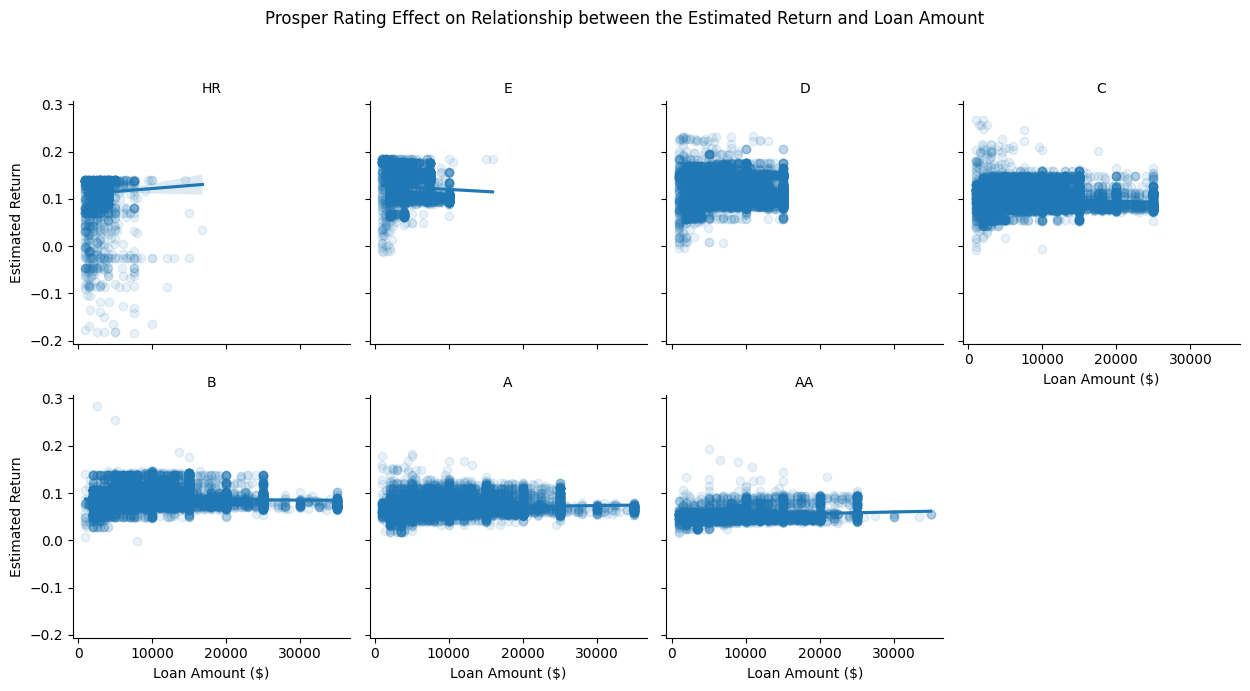

In [11]:
# Prosper rating effect on relationship of the estimated return and loan amount
g=sb.FacetGrid(data=df_loans_filtered, height=3.5,aspect=.9,  col='ProsperRatingAlpha', col_wrap=4)
g.map(sb.regplot, 'LoanOriginalAmount', 'EstimatedReturn', x_jitter=0.04, scatter_kws={'alpha':0.1})
g.set_titles('{col_name}')
g.set_xlabels('Loan Amount ($)')
g.set_ylabels('Estimated Return')
plt.suptitle('Prosper Rating Effect on Relationship between the Estimated Return and Loan Amount')
plt.subplots_adjust(top=0.85)

## Estimated Return by Rating and Term

In general, the return decreases with the increasing of the prosper rating, for all the term bins.<br>
If we compare the Return within the same rating group term wise, we can notice that longer terms yield higher returns.<br>
The lesson learned here is that the prosper rating has more impact in the magnitude of the return than the term itself.<br> 
Interestingly, within the same term bin, borrowers in the High Risk (HR) group return approximately twice as much as the highest rated group of borrowers (AA). This corroborates to the previous chart, that show a higher return for customers in the high risk.

In [12]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = df_loans_filtered, x = 'ProsperRatingAlpha', y = 'EstimatedReturn', hue = 'Term',
           palette = 'Blues', linestyles = '', dodge = 0.4, errorbar='sd')
plt.title('Estimated Return across Rating and Term')
plt.ylabel('Mean Estimated Return')
plt.xlabel('Prosper Rating')
ax.set_yticklabels([],minor = True);

In [ ]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt